In [5]:
import folium
from folium.plugins import MarkerCluster
import geopandas as gpd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns

from networkx.algorithms import approximation as approx
import networkx as nx

import numpy as np
import random

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

import pandas as pd

# L0. Problem statement and target definition

## Problem statement

**Problem** $-$ find an optimal route of delivering goods across the offices, w.r.t. the cost and time of this route.

In [2]:
data = pd.read_csv("wb_school_task_3.csv.gzip", compression="gzip")

In [3]:
data.head(n=5)

,count,max,max.1,dst_office_id,office_name,latitude,longitude
0,379,2023-04-24,507,105643,МО Одинцово Садовая 24,55.676228,37.248839
1,249,2023-04-24,507,133447,МО Кашира Ленина 15,54.844701,38.191166
2,345,2023-04-24,507,110999,МО Одинцово Сколковская 1Б,55.694942,37.324654
3,591,2023-04-24,507,5807,Подольск Победы 12,55.360190,37.512755
4,322,2023-04-24,507,3300,МО Свердловский Строителей 22,55.903330,38.155216


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   count          1800 non-null   int64  
 1   max            1800 non-null   object 
 2   max.1          1800 non-null   int64  
 3   dst_office_id  1800 non-null   int64  
 4   office_name    1800 non-null   object 
 5   latitude       1800 non-null   float64
 6   longitude      1800 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 98.6+ KB


As we can see, it's a classical capacitated vehicle routing problem (CVRP).

The CVRP can be described as a graph $G = (N, E)$, where:

$N = \{0, \dots, n\}$ $-$ set of nodes, where node 0 is a depot and a set $\{1, \dots, n\}$ represents customers.

$i \in N'$ is a customer, where $N' = N \setminus \{0\}$.

$V = \{1, \dots, k\}$ $-$ set of vehicles.

$Q$ $-$ maximal vehicle capacity.

$m_i$ is a customer's demand, where $i = \{1, \dots, n\}$.

$E = \{(i, j) \colon i, j \in V\}$ $-$ set of edges.

$d_{ij}$ $-$ edge's cost (distance between two edges), such that $d_{ij} > 0$.

**The decision variable**:

$$
    x_{ijk} =
    \begin{cases}
        1,&\text{if vehicle $k$ travels from custimer $i$ to $j$}\\
        0,&\text{otherwise}
    \end{cases}
$$

**The objective function**:

$\text{Minimize} \sum\limits_{k \in V} \sum\limits_{i \in N} \sum\limits_{j \in N} d_{ij} \cdot x_{ijk},$

s.t.:

1. $\sum\limits_{k \in V} \sum\limits_{i \in N} x_{ijk} = 1, \forall j \in N$
2. $\sum\limits_{k \in V} \sum\limits_{j \in N} x_{ijk} = 1, \forall i \in N$
3. $\sum\limits_{i \in N} m_i \sum\limits_{j \in N} x_{ijk} \leq Q$
4. $\sum\limits_{j \in N} x_{0jk} = 1, \forall k \in V$
5. $\sum\limits_{i \in N} x_{i0k} = 1, \forall k \in V$
6. $\sum\limits_{i \in N} x_{ihk} - \sum\limits_{j \in N} x_{hjk} = 0, \forall h \in N, \forall k \in V$
7. $x_{ijk} = \{0, 1\}, i \neq j, \forall i, j \in N, \forall k \in V$

Information about the starting point (the warehouse):

In [3]:
whs_latitude = 55.386170
whs_longitude = 37.583832
whs_name = "МО Подольск склад Коледино"

# L1. EDA

In [6]:
def get_nan_values(df: pd.DataFrame, feature_name: str) -> np.int64:
    return df[feature_name].isna().sum()

In [7]:
def get_unique_values(df: pd.DataFrame, feature_name: str) -> int:
    return len(df[feature_name].unique())

## `count`

In [8]:
print(f"Number of NaN-values: {get_nan_values(df=data, feature_name='count')}")

Number of NaN-values: 0


In [12]:
print(f'Number of "empty routes": {(data.iloc[:, 0] < 1).sum()}')

Number of "empty routes": 0


In [14]:
print("Min load value:", data.iloc[:, 0].min())
print("Max load value:", data.iloc[:, 0].max())
print("Median load value:", data.iloc[:, 0].median())

Min load value: 3
Max load value: 1981
Median load value: 455.5


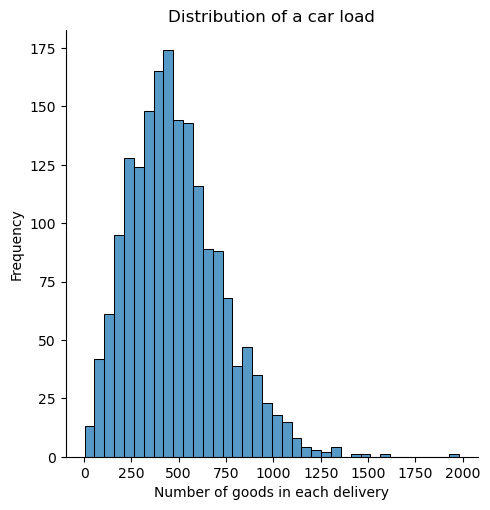

In [15]:
sns.displot(data.iloc[:, 0])
plt.xlabel("Number of goods in each delivery")
plt.ylabel("Frequency")
plt.title("Distribution of a car load");

Have a look at the number of unique car loads.

In [16]:
print(f"Number of unique values: {get_unique_values(df=data, feature_name='count')}")

Number of unique values: 803


Obviously, this number can repeat because of the following reasons simultaniously:
1. Data duplicates.
2. Just the same load for the specific office(s).
3. Each non-unique value equals to the specific route.

**Notes**:
1. Rename the feature to `load`.
2. Try to find any connections between load and exact office(s). For example, devide the range of load into parts and then try to find any dependences with the exact office.

## `max`

In [17]:
print(f"Number of NaN-values: {get_nan_values(df=data, feature_name='max')}")

Number of NaN-values: 0


In [18]:
print(f"Number of unique values: {get_unique_values(df=data, feature_name='max')}")

Number of unique values: 1


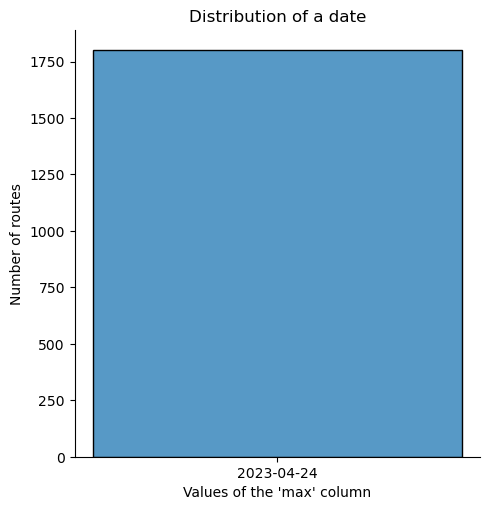

In [19]:
sns.displot(data["max"])
plt.xlabel("Values of the 'max' column")
plt.ylabel("Number of routes")
plt.title("Distribution of a date");

So, this column just consists of the same value for each row. There are no timestampts and etc. Therefore, we can rid of this feature in the future.

**Notes**:
1. Get rid of this feature.

## `max.1`

In [20]:
print(f"Number of NaN-values: {get_nan_values(df=data, feature_name='max.1')}")

Number of NaN-values: 0


In [21]:
print(f"Number of unique values: {get_unique_values(df=data, feature_name='max.1')}")

Number of unique values: 1


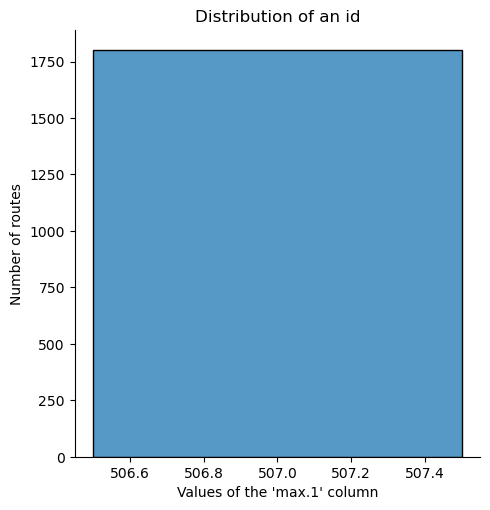

In [22]:
sns.displot(data["max.1"])
plt.xlabel("Values of the 'max.1' column")
plt.ylabel("Number of routes")
plt.title("Distribution of an id");

The same situation as in the previous case. This column just consists of id's of the warehouse.

**Notes**:
1. Rename the feature to `whs_id`.

## `dst_office_id`

In [23]:
print(f"Number of NaN-values: {get_nan_values(df=data, feature_name='dst_office_id')}")

Number of NaN-values: 0


In [24]:
print(f"Number of unique values: {get_unique_values(df=data, feature_name='dst_office_id')}")

Number of unique values: 1800


There are 1800 unique values. This means that each route from warehouse to office is unique. In other words, there are no such situations when a car needs to deliver goods to several offices on its way.

## `office_name`

In [25]:
print(f"Number of NaN-values: {get_nan_values(df=data, feature_name='office_name')}")

Number of NaN-values: 0


In [26]:
print(f"Number of unique values: {get_unique_values(df=data, feature_name='office_name')}")

Number of unique values: 1800


So, the same situation as in the `dst_office_id` case. `office_name` is just a categorical representation of `dst_office_id`.

**Notes**:
1. Encode the names of the offices in the future if necessary.

## `latitude`

In [27]:
print(f"Number of NaN-values: {get_nan_values(df=data, feature_name='latitude')}")

Number of NaN-values: 0


In [28]:
print(f"Number of unique values: {get_unique_values(df=data, feature_name='latitude')}")

Number of unique values: 1798


There are only 1798 unique values instead of 1800 as expected. However, the overlapping of latitude can be explained by the nature of this type of data (means, coordinate data). But let's try to find the exact non-unique coordinates.

In [29]:
def get_non_unique(df: pd.DataFrame, feature_name: str) -> pd.DataFrame:
    duplicates = df[feature_name][data[feature_name].duplicated(keep=False)]
    non_unique_values = duplicates.value_counts().loc[lambda x: x > 1].index.tolist()
    non_unique = df[df[feature_name].isin(non_unique_values)]
    return non_unique

In [30]:
non_unique_latitude = get_non_unique(df=data, feature_name="latitude")
display(non_unique_latitude)

,count,max,max.1,dst_office_id,office_name,latitude,longitude
125,271,2023-04-24,507,528,МО Орехово-Зуево Урицкого 58,55.813410,38.968971
781,444,2023-04-24,507,207491,МСК Проезд Ольминского 6с1,55.813410,37.631838
994,542,2023-04-24,507,105921,МСК Мастеркова 6,55.707983,37.656782
1296,774,2023-04-24,507,110878,МСК Рождественская 29,55.707983,37.927346


**Notes**:

1. Rename this feature to `dst_latitude`.

## `longitude`

In [31]:
print(f"Number of NaN-values: {get_nan_values(df=data, feature_name='longitude')}")

Number of NaN-values: 0


In [32]:
print(f"Number of unique values: {get_unique_values(df=data, feature_name='longitude')}")

Number of unique values: 1798


In [33]:
non_unique_longitude = get_non_unique(df=data, feature_name="longitude")
display(non_unique_longitude)

,count,max,max.1,dst_office_id,office_name,latitude,longitude
51,337,2023-04-24,507,834,МСК Лётчика Бабушкина 6,55.859200,37.674346
282,207,2023-04-24,507,161047,МСК Ягодная 8к3,55.575078,37.674346
802,378,2023-04-24,507,103638,МО Королёв Тихонравова 44/2,55.937060,37.853607
1584,374,2023-04-24,507,3552,МСК Николая Старостина 9,55.731524,37.853607


So, we can compare two DataFrame slices $-$ `non_unique_latitude` and `non_unique_longitude`. As we see, "non-unique" coordinates which have been called like that before, actually don't lead to any duplicates or something like that. If we compare tuples `(latitude, longitude)`, we'll figure out that everything is fine $-$ all the offices are unique.

**Notes**:

1. Rename this feature to `dst_longitude`.

## `latitude` + `longitude`

Let's visualize our coordinates on the 2D plane.

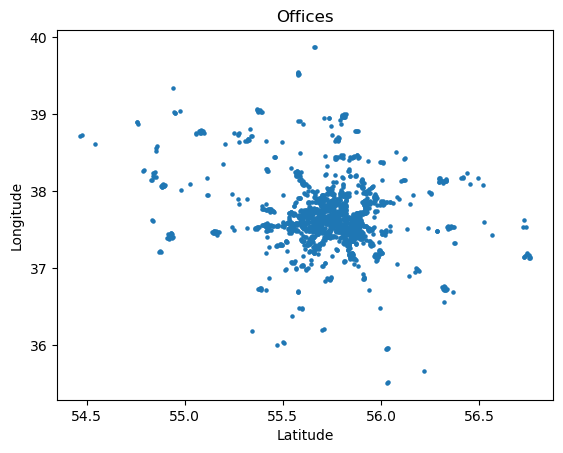

In [34]:
plt.scatter(data["latitude"], data["longitude"], s=5)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Offices")
plt.show()

And now let's make the visualization above more interactive.

In [35]:
markers = [folium.Marker([lat, lon], tooltip=label) for lat, lon, label in zip(data["latitude"], 
                                                                               data["longitude"], 
                                                                               data["office_name"])]
# Color of the warehouse is red.
whs_marker = folium.Marker([whs_latitude, whs_longitude], tooltip=whs_name, icon=folium.Icon(color="red")) 
markers.append(whs_marker)
map = folium.Map(location=[data["latitude"].mean(), data["longitude"].mean()], zoom_start=10)
marker_cluster = MarkerCluster().add_to(map)

for marker in markers:
    marker.add_to(marker_cluster)

display(map)

# Changes after EDA

Let's apply the changes from EDA notes.

In [4]:
data.rename(columns={"latitude": "dst_latitude", "longitude": "dst_longitude"}, inplace=True)
data.rename(columns={"max.1": "whs_id"}, inplace=True)
data.rename(columns={"count": "load"}, inplace=True)

data = data.drop("max", axis=1)

data["whs_latitude"] = whs_latitude
data["whs_longitude"] = whs_longitude

# L2. Research of existing solutions

[Link Review](https://docs.google.com/document/d/1cSFK201Fbct4dFawmqWqdOr6U1i13TICpTdY7tPMozE/edit?usp=sharing).

# L3. Samples' formation

There's no such stage because of the task specificity. 

# L4-L5. Solutions using a graph

In [37]:
data.head(n=5)

,load,whs_id,dst_office_id,office_name,dst_latitude,dst_longitude,whs_latitude,whs_longitude
0,379,507,105643,МО Одинцово Садовая 24,55.676228,37.248839,55.38617,37.583832
1,249,507,133447,МО Кашира Ленина 15,54.844701,38.191166,55.38617,37.583832
2,345,507,110999,МО Одинцово Сколковская 1Б,55.694942,37.324654,55.38617,37.583832
3,591,507,5807,Подольск Победы 12,55.360190,37.512755,55.38617,37.583832
4,322,507,3300,МО Свердловский Строителей 22,55.903330,38.155216,55.38617,37.583832


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   load           1800 non-null   int64  
 1   whs_id         1800 non-null   int64  
 2   dst_office_id  1800 non-null   int64  
 3   office_name    1800 non-null   object 
 4   dst_latitude   1800 non-null   float64
 5   dst_longitude  1800 non-null   float64
 6   whs_latitude   1800 non-null   float64
 7   whs_longitude  1800 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 112.6+ KB


In [41]:
def calculate_distance(dst1_latitude: np.float64, 
                       dst1_longitude: np.float64, 
                       dst2_latitude: np.float64, 
                       dst2_longitude: np.float64) -> np.float64:
    distance = geodesic((dst2_latitude, dst2_longitude), (dst1_latitude, dst1_longitude)).km
    return distance

In [39]:
whs_id = data.iloc[0, 1]

## Graph creation

In [ ]:
# Create an empty graph.
graph = nx.Graph()

graph.add_node(whs_id, latitude=whs_latitude, longitude=whs_longitude)

# Add destination nodes to the graph.
for _, row in data.iterrows():
    destination_id = row["dst_office_id"]
    latitude = row["dst_latitude"]
    longitude = row["dst_longitude"]
    graph.add_node(destination_id, latitude=latitude, longitude=longitude)

In [ ]:
# Add edges to the graph with distances.
num_destinations = len(data)
for i in range(num_destinations):
    for j in range(i + 1, num_destinations):
        dest1_id = data.iloc[i]["dst_office_id"]
        dest1_lat = data.iloc[i]["dst_latitude"]
        dest1_lon = data.iloc[i]["dst_longitude"]
        dest2_id = data.iloc[j]["dst_office_id"]
        dest2_lat = data.iloc[j]["dst_latitude"]
        dest2_lon = data.iloc[j]["dst_longitude"]
        distance = calculate_distance(dest1_lat, dest1_lon, dest2_lat, dest2_lon)
        graph.add_edge(dest1_id, dest2_id, distance=distance)

In [ ]:
# Add edges to the graph from the warehouse to each destination office.
for i in range(num_destinations):
    dest_id = data.iloc[i]["dst_office_id"]
    dest_lat = data.iloc[i]["dst_latitude"]
    dest_lon = data.iloc[i]["dst_longitude"]
    distance = calculate_distance(whs_latitude, whs_longitude, dest_lat, dest_lon)
    graph.add_edge(whs_id, dest_id, distance=distance)

In [ ]:
# Save the graph, so we won't have to create it every time.
nx.write_graphml(graph, "my_graph.graphml")

## Graph loading

In [42]:
# Load the graph.
graph = nx.read_graphml("my_graph.graphml")

In [43]:
print("Number of nodes in the graph:", len(graph.nodes))

Number of nodes in the graph: 1801


In [44]:
print("Number of edges in the graph:", len(graph.edges))

Number of edges in the graph: 1620900


## Algorithms developing

### Nearest Neighbor heuristic algorithm

This solution just creates a cycle on the graph. It doesn't consider any constrains. 

In [46]:
# Nearest Neighbor heuristic algorithm to find an optimal route.
def nearest_neighbor(graph: nx.graph, source: str) -> list:
    unvisited = set(graph.nodes) - {source}
    current_node = source
    route = [source]

    while unvisited:
        nearest_node = min(unvisited, key=lambda node: graph[current_node][node]["distance"])
        route.append(nearest_node)
        unvisited.remove(nearest_node)
        current_node = nearest_node

    route.append(source)  # Return to the source node to complete the route.
    return route

In [47]:
# Find the optimal route starting from the warehouse using the Nearest Neighbor algorithm.
optimal_nn_route = nearest_neighbor(graph, "507")
print("Optimal NN route:", optimal_nn_route)

Optimal NN route: ['507', '107424', '2997', '105102', '128439', '2741', '3207', '113336', '206193', '107969', '108474', '2821', '108667', '144259', '2915', '204727', '150127', '2996', '113030', '110509', '107426', '105818', '1839', '107912', '2331', '6078', '5321', '205314', '106320', '114051', '110547', '106811', '142406', '113074', '137519', '132505', '105998', '111883', '206200', '114614', '5745', '204589', '566', '172032', '107220', '218613', '204195', '104223', '106047', '2012', '5511', '105508', '105149', '205320', '986', '130961', '105740', '112009', '2201', '144206', '107729', '110481', '204873', '129208', '107770', '111357', '102752', '2056', '105021', '203485', '141620', '107927', '107839', '104989', '113289', '172010', '113430', '2307', '155419', '110559', '203875', '204860', '3613', '584', '113618', '113482', '203346', '107932', '105790', '1931', '109169', '128896', '204917', '107992', '110614', '113815', '142988', '561', '111429', '5090', '111617', '113249', '3803', '20425

### Algorithms evaluation

Let's create again a cycle but now using `greedy_tsp` function from [NetworkX library](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.approximation.traveling_salesman.greedy_tsp.html).

In [51]:
greedy_tsp_algo = approx.greedy_tsp(graph, source="507")
cost_greedy_tsp = sum(graph[n][nbr]["distance"] for n, nbr in nx.utils.pairwise(greedy_tsp_algo))
cost_nn_algo = sum(graph[n][nbr]["distance"] for n, nbr in nx.utils.pairwise(optimal_nn_route))

In [56]:
print("Are there an equal number of unique elements using those solutions?:", 
      len(set(optimal_nn_route)) == len(set(greedy_tsp_algo)))

Are there an equal number of unique elements using those solutions?: True


In [52]:
print(f"Greedy TSP algorithm cost in terms of distance: {cost_greedy_tsp} km")

Greedy TSP algorithm cost in terms of distance: 84246.71822210058 km


In [50]:
print(f"Nearest Neighbor algorithm cost in terms of distance: {cost_nn_algo} km")

Nearest Neighbor algorithm cost in terms of distance: 3962.1622494072385 km


# L4-L5. Solutions using a distance matrix

In [8]:
data.head(n=5)

,load,whs_id,dst_office_id,office_name,dst_latitude,dst_longitude,whs_latitude,whs_longitude
0,379,507,105643,МО Одинцово Садовая 24,55.676228,37.248839,55.38617,37.583832
1,249,507,133447,МО Кашира Ленина 15,54.844701,38.191166,55.38617,37.583832
2,345,507,110999,МО Одинцово Сколковская 1Б,55.694942,37.324654,55.38617,37.583832
3,591,507,5807,Подольск Победы 12,55.360190,37.512755,55.38617,37.583832
4,322,507,3300,МО Свердловский Строителей 22,55.903330,38.155216,55.38617,37.583832


Let's add an additinal row to our initial dataset which will show the data about the warehouse.

In [9]:
whs_row = pd.DataFrame({"load": 0, "whs_id": 507, "dst_office_id": 507, "office_name": whs_name, 
                        "dst_latitude": whs_latitude, "dst_longitude": whs_longitude,
                        "whs_latitude": whs_latitude, "whs_longitude": whs_longitude}, index=[0])
data_whs = pd.concat([whs_row, data.loc[:]]).reset_index(drop=True)

In [59]:
data_whs.head(n=5)

,load,whs_id,dst_office_id,office_name,dst_latitude,dst_longitude,whs_latitude,whs_longitude
0,0,507,507,МО Подольск склад Коледино,55.386170,37.583832,55.38617,37.583832
1,379,507,105643,МО Одинцово Садовая 24,55.676228,37.248839,55.38617,37.583832
2,249,507,133447,МО Кашира Ленина 15,54.844701,38.191166,55.38617,37.583832
3,345,507,110999,МО Одинцово Сколковская 1Б,55.694942,37.324654,55.38617,37.583832
4,591,507,5807,Подольск Победы 12,55.360190,37.512755,55.38617,37.583832


Prepare our features for an entity (so called, data model) that will include all the necessary data. 

In [27]:
car_load = data_whs.iloc[:, 0].tolist()
dst_ids = data_whs.iloc[:, 2].tolist()
lats = data_whs.iloc[:, 4].tolist()
longs = data_whs.iloc[:, 5].tolist()

## Distance matrix creation

In [61]:
def create_distance_matrix(df: pd.DataFrame):
    # Number of destinations
    num_destinations = len(df)

    # Create an empty distance matrix array
    distance_matrix = np.zeros((num_destinations, num_destinations))

    # Iterate over each destination pair
    for i in range(num_destinations):
        for j in range(num_destinations):
            if i != j:
                # Calculate the distance between two destinations
                distance = geodesic((df.loc[i, "dst_latitude"], df.loc[i, "dst_longitude"]),
                                    (df.loc[j, "dst_latitude"], df.loc[j, "dst_longitude"])).kilometers
                # Assign the distance to the matrix
                distance_matrix[i, j] = distance

    np.save("distance_matrix.npy", distance_matrix)

In [ ]:
create_distance_matrix(df=data_whs)

## Distance matrix loading

In [34]:
# We need an integer datatype to use Google OR-Tools.
distance_matrix = np.load("distance_matrix.npy").astype(int)

In [12]:
print(distance_matrix)

[[  0  38  71 ...  31  92 110]
 [ 38   0 110 ...  34  98  91]
 [ 71 110   0 ...  91 120 165]
 ...
 [ 31  34  91 ...   0  67  79]
 [ 92  98 120 ...  67   0  64]
 [110  91 165 ...  79  64   0]]


## Google OR-Tools

In [28]:
def create_data_model(distance_matrix: np.ndarray, num_vehicles: int) -> dict:
    # Stores the data for the problem.
    data = {}

    data["distance_matrix"] = distance_matrix
    data["demands"] = car_load
    # 456 is the rounded median car load value.
    # 1981 is the maximum car load value.
    data["vehicle_capacities"] = [1981] * num_vehicles 
    data["num_vehicles"] = num_vehicles
    data["depot"] = 0
    data["destination_ids"] = dst_ids
    data["lats"] = lats
    data["longs"] = longs
    return data

CVRP:

In [30]:
def print_solution(data: dict, manager: pywrapcp.RoutingIndexManager, 
                   routing: pywrapcp.RoutingModel, assignment: pywrapcp.Assignment):
    """Prints assignment on console."""
    print(f"Objective: {assignment.ObjectiveValue()}")
    # Display dropped nodes.
    dropped_nodes = "Dropped nodes:"
    amount_dropped_nodes = 0
    for node in range(routing.Size()):
        if routing.IsStart(node) or routing.IsEnd(node):
            continue
        if assignment.Value(routing.NextVar(node)) == node:
            amount_dropped_nodes += 1
            dropped_nodes += " {}".format(manager.IndexToNode(node))
    print(dropped_nodes)
    print(f"Amount of dropped nodes: {amount_dropped_nodes} \n")
    # Display routes.
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = "Route for vehicle {}:\n".format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            if node_index == 0:
                plan_output += " {0} Load({1}) -> ".format("Warehouse", route_load)
            else:
                plan_output += " {0} Load({1}) -> ".format(data["destination_ids"][node_index - 1], 
                                                           data["demands"][node_index])
            previous_index = index
            index = assignment.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += " {0} Load({1})\n".format("Warehouse",
                                                 route_load)
        plan_output += "Distance of the route: {} km\n".format(route_distance)
        plan_output += "Load of the route: {}\n".format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print("Total Distance of all routes: {} km".format(total_distance))
    print("Total Load of all routes: {}".format(total_load))

In [31]:
def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    # Number of vehicles is between 200 and 300.
    or_google_data = create_data_model(distance_matrix=distance_matrix, num_vehicles=450)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(or_google_data["distance_matrix"]),
                                           or_google_data["num_vehicles"], or_google_data["depot"])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return or_google_data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)


    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return or_google_data["demands"][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(
        demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # Null capacity slack.
        or_google_data["vehicle_capacities"],  # Vehicle maximum capacities.
        True,  # Start cumul to zero.
        "Capacity")
    # Allow to drop nodes.
    penalty = 1000
    for node in range(1, len(or_google_data["distance_matrix"])):
        routing.AddDisjunction([manager.NodeToIndex(node)], penalty)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.FromSeconds(4)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(or_google_data, manager, routing, solution)
    else:
        print("There's no solution")

if __name__ == "__main__":
    main()

Objective: 55083
Dropped nodes:
Amount of dropped nodes: 0 

Route for vehicle 0:
 Warehouse Load(0) ->  Warehouse Load(0)
Distance of the route: 0 km
Load of the route: 0

Route for vehicle 1:
 Warehouse Load(0) ->  173053 Load(423) ->  123778 Load(611) ->  3044 Load(835) ->  Warehouse Load(1869)
Distance of the route: 309 km
Load of the route: 1869

Route for vehicle 2:
 Warehouse Load(0) ->  102282 Load(490) ->  103741 Load(377) ->  107468 Load(611) ->  2983 Load(491) ->  Warehouse Load(1969)
Distance of the route: 312 km
Load of the route: 1969

Route for vehicle 3:
 Warehouse Load(0) ->  104048 Load(624) ->  2414 Load(357) ->  105733 Load(323) ->  1051 Load(378) ->  107969 Load(224) ->  Warehouse Load(1906)
Distance of the route: 425 km
Load of the route: 1906

Route for vehicle 4:
 Warehouse Load(0) ->  107821 Load(420) ->  3686 Load(200) ->  1915 Load(448) ->  111105 Load(328) ->  3933 Load(374) ->  Warehouse Load(1770)
Distance of the route: 512 km
Load of the route: 1770

Rout

## Create `.vrp` file 

In [32]:
def dict_to_vrp_file(data: dict, file_path: str):
    with open(file_path, "w") as file:
        # Write the VRP header.
        file.write("NAME: Capacitated Vehicle Routing Problem\n")
        file.write("TYPE: CVRP\n")
        file.write(f"DIMENSION: {len(data['distance_matrix'])}\n")
        file.write(f"EDGE_WEIGHT_TYPE: EXPLICIT\n")
        file.write("EDGE_WEIGHT_FORMAT: FULL_MATRIX\n")
        file.write("EDGE_WEIGHT_SECTION\n")

        # Write the distance matrix.
        distance_matrix = data["distance_matrix"]
        for row in distance_matrix:
            line = " ".join(str(dist) for dist in row)
            file.write(line + "\n")

        # Write the VRP demands section.
        file.write("DEMAND_SECTION\n")
        demands = data["demands"]
        for demand in demands:
            file.write(str(demand) + "\n")

        # Write the VRP capacity section.
        file.write("CAPACITY: ")
        vehicle_capacities = data["vehicle_capacities"]
        file.write(" ".join(str(capacity) for capacity in vehicle_capacities) + "\n")

        # Write the VRP depot section.
        file.write("DEPOT_SECTION\n")
        depot = data["depot"]
        file.write(str(depot) + "\n")

        # Write the VRP destinations section.
        file.write("LOCATION_COORDINATES_SECTION\n")
        destination_ids = data["destination_ids"]
        lats = data["lats"]
        longs = data["longs"]
        for i, destination_id in enumerate(destination_ids):
            lat = lats[i]
            lon = longs[i]
            file.write(f"{destination_id} {lat} {lon}\n")

        # Write the VRP footer.
        file.write("EOF\n")

In [35]:
data_for_vrp = create_data_model(distance_matrix=distance_matrix, num_vehicles=450)
dict_to_vrp_file(data_for_vrp, "output.vrp")